In [ ]:
!pip install transformers datasets matplotlib
!pip install torchvision scikit-learn

# Import libraries
from transformers import CLIPProcessor, CLIPModel
from torchvision import transforms, models, datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch import nn, optim
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from PIL import Image, UnidentifiedImageError
import torch
import matplotlib.pyplot as plt
from collections import Counter
from glob import glob
import os
import numpy as np
import hashlib
import pandas as pd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Define dataset paths
train_path = "/content/drive/MyDrive/finalproject/dataset/train" #based on my file path to train
test_path = "/content/drive/MyDrive/finalproject/dataset/test" #based on my file path to test
categories = ["shirt", "dress", "shoes"]

Mounted at /content/drive


Category: shirt, Samples: 8


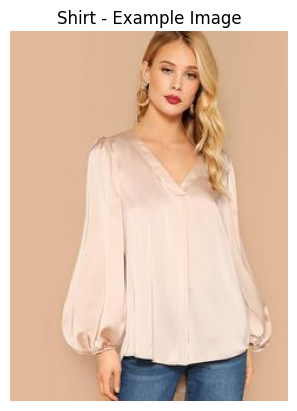

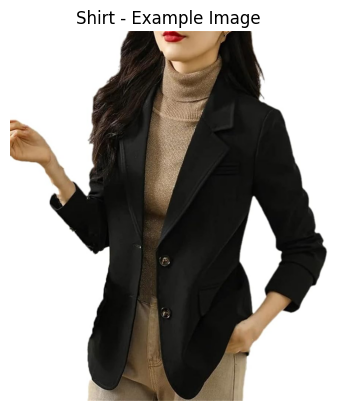

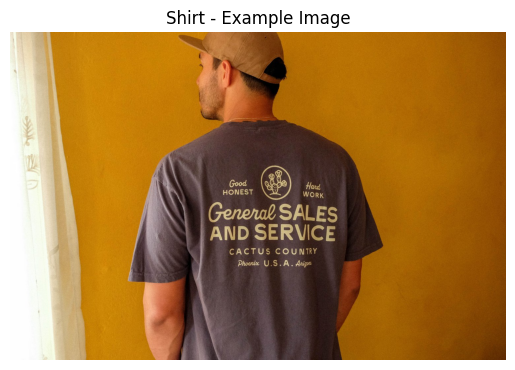

Category: dress, Samples: 8


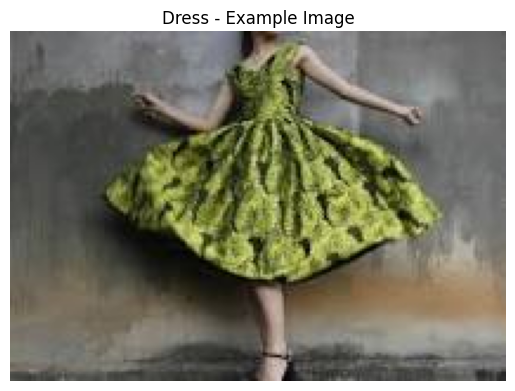

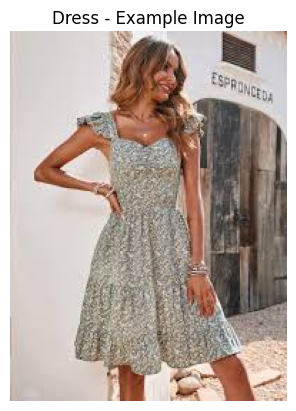

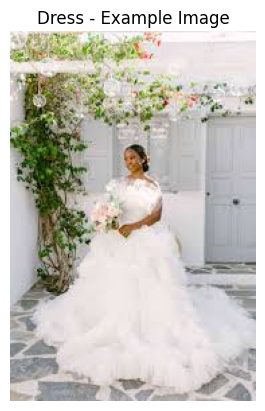

Category: shoes, Samples: 7


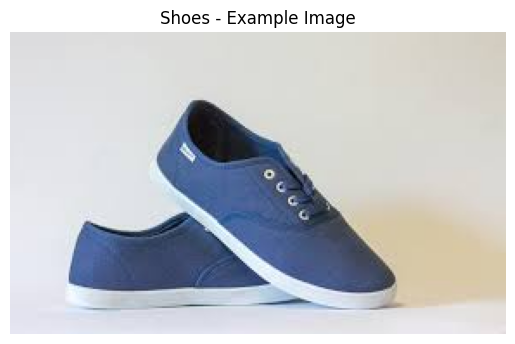

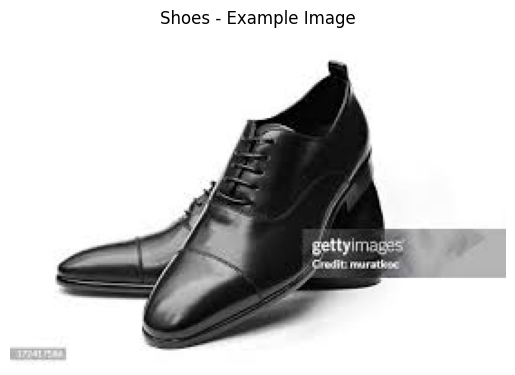

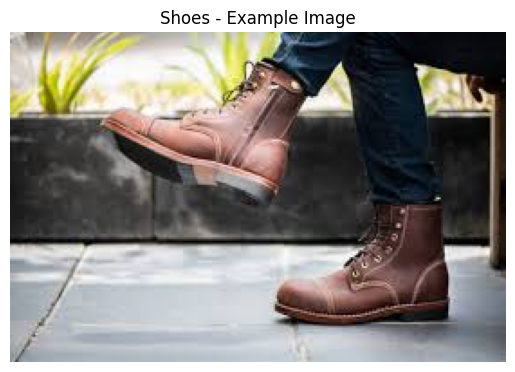

In [ ]:
# Visualize dataset with descriptions
for category in categories:
    images = glob(f"{train_path}/{category}/*.*")
    print(f"Category: {category}, Samples: {len(images)}")
    for img_path in images[:3]:  # Display 3 images per category
        img = Image.open(img_path)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{category.capitalize()} - Example Image")
        plt.show()

In [ ]:
def hash_image(image_path):
    with open(image_path, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

train_images = [hash_image(img) for img in glob(f"{train_path}/*/*")]
test_images = [hash_image(img) for img in glob(f"{test_path}/*/*")]

duplicates = set(train_images) & set(test_images)
if duplicates:
    print(f"Found {len(duplicates)} duplicate images between train and test!")
else:
    print("No duplicates found.")

No duplicates found.


In [ ]:
from torchvision.transforms import functional as TF

# Define the augmentation function
augmentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Apply augmentations and save augmented images
def augment_image(image_path):
    try:
        image = Image.open(image_path).convert("RGB")
        augmented_image = augmentation_transform(image)
        augmented_image = TF.to_pil_image(augmented_image)
        save_path = image_path.replace("train", "augmented_train")
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        augmented_image.save(save_path)
    except Exception as e:
        print(f"Error augmenting {image_path}: {e}")

from multiprocessing import Pool

with Pool(4) as p:  # Adjust number of processes
    p.map(augment_image, glob(f"{train_path}/**/*.*", recursive=True))


In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets
train_dataset = ImageFolder(root=train_path, transform=transform)
test_dataset = ImageFolder(root=test_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Class distribution
counts = Counter(train_dataset.targets)
print("Class distribution:", counts)


Class distribution: Counter({0: 8, 1: 8, 2: 7})


In [ ]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").cuda()
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
prompts = [f"A photo of a {category}" for category in categories]

def predict_clip(image_path, prompts):
    image = Image.open(image_path)
    inputs = processor(text=prompts, images=image, return_tensors="pt", padding=True).to("cuda")
    outputs = clip_model(**inputs)
    logits_per_image = outputs.logits_per_image
    predicted_idx = logits_per_image.argmax().item()
    return prompts[predicted_idx].split()[-1]

# Test CLIP predictions
for img_path in glob(f"{test_path}/*/*.jpg")[:5]:
    print(f"Image: {img_path}, Predicted: {predict_clip(img_path, prompts)}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Image: /content/drive/MyDrive/finalproject/dataset/test/shoes/s1.jpg, Predicted: shoes
Image: /content/drive/MyDrive/finalproject/dataset/test/shoes/s2.jpg, Predicted: shoes
Image: /content/drive/MyDrive/finalproject/dataset/test/shoes/s3.jpg, Predicted: shoes
Image: /content/drive/MyDrive/finalproject/dataset/test/shoes/s4.jpg, Predicted: shoes
Image: /content/drive/MyDrive/finalproject/dataset/test/shoes/s5.jpg, Predicted: shoes


In [ ]:
resnet_model = models.resnet18(pretrained=True)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, len(train_dataset.classes))
resnet_model = resnet_model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)

# Train ResNet
num_epochs = 10
for epoch in range(num_epochs):
    resnet_model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = resnet_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Accuracy: {train_accuracy:.2f}%")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 197MB/s]


Epoch [1/10], Loss: 2.1096, Accuracy: 60.87%
Epoch [2/10], Loss: 1.3219, Accuracy: 86.96%
Epoch [3/10], Loss: 0.4778, Accuracy: 86.96%
Epoch [4/10], Loss: 1.0976, Accuracy: 91.30%
Epoch [5/10], Loss: 1.3530, Accuracy: 91.30%
Epoch [6/10], Loss: 0.6438, Accuracy: 91.30%
Epoch [7/10], Loss: 0.8428, Accuracy: 95.65%
Epoch [8/10], Loss: 2.3448, Accuracy: 73.91%
Epoch [9/10], Loss: 0.3097, Accuracy: 95.65%
Epoch [10/10], Loss: 2.0299, Accuracy: 78.26%


In [ ]:
# Evaluate ResNet
resnet_model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.cuda(), labels.cuda()
        outputs = resnet_model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Metrics
accuracy_resnet = accuracy_score(y_true, y_pred)
f1_score_resnet = f1_score(y_true, y_pred, average="weighted")
print(f"ResNet18 Accuracy: {accuracy_resnet * 100:.2f}%, F1-Score: {f1_score_resnet:.2f}")

# Evaluate CLIP
y_true_clip, y_pred_clip = [], []
for img_path in glob(f"{test_path}/*/*.jpg"):
    true_label = os.path.basename(os.path.dirname(img_path))
    predicted_label = predict_clip(img_path, prompts)
    y_true_clip.append(categories.index(true_label))
    y_pred_clip.append(categories.index(predicted_label))

accuracy_clip = accuracy_score(y_true_clip, y_pred_clip)
f1_score_clip = f1_score(y_true_clip, y_pred_clip, average="weighted")
print(f"CLIP Accuracy: {accuracy_clip * 100:.2f}%, F1-Score: {f1_score_clip:.2f}")

ResNet18 Accuracy: 45.83%, F1-Score: 0.39
CLIP Accuracy: 100.00%, F1-Score: 1.00


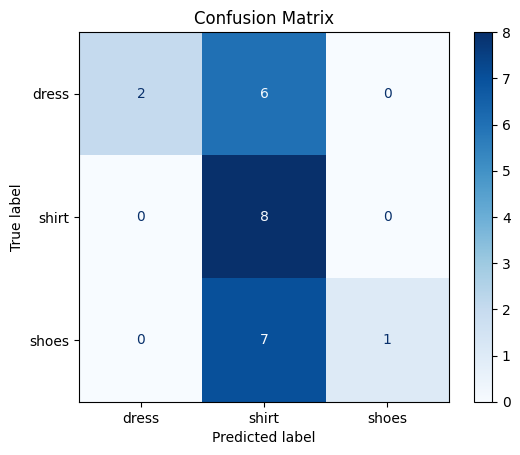

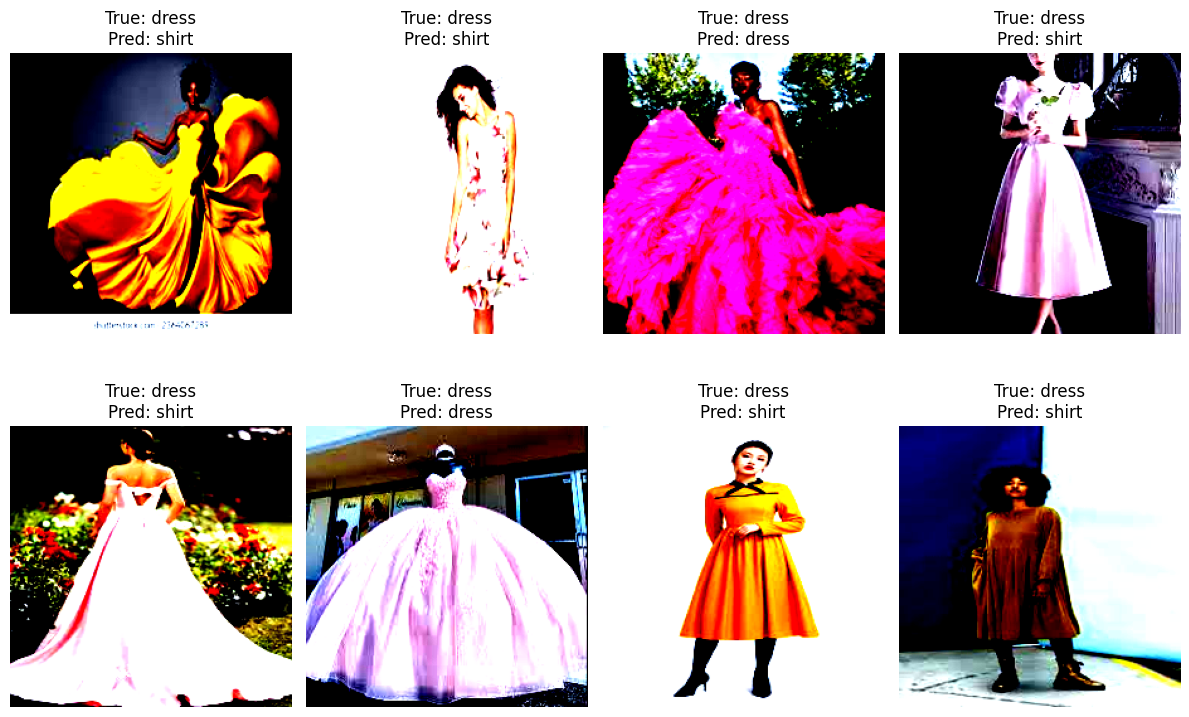

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Visualization
data_iter = iter(test_loader)
images, labels = next(data_iter)
images = images.cuda()
outputs = resnet_model(images)
_, predicted = torch.max(outputs, 1)

plt.figure(figsize=(12, 8))
for idx in range(len(images)):
    plt.subplot(2, 4, idx + 1)
    plt.imshow(images[idx].permute(1, 2, 0).cpu().numpy())
    plt.title(f"True: {test_dataset.classes[labels[idx]]}\nPred: {test_dataset.classes[predicted[idx]]}")
    plt.axis("off")
plt.tight_layout()
plt.show()
